In [2]:
import os
from pathlib import Path 
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
df = pd.read_csv("/home/javio/Audio/CommonVoice/Spanish/test.tsv",sep='\t')
df = pd.read_csv('syndf.csv',sep='\t')
import subprocess
from joblib import Parallel, delayed
import multiprocessing
import time

# <center> How to create a synthetic corpus dataset

In [2]:
df = pd.read_csv("/home/javio/Audio/Common Voice/Spanish/test.tsv",sep='\t')

We have two different folders, SYNclips y SYNPollyclips

SYNclips follows the following structure : 'SYN' + '_'+voice[7:]+'_'+df.path[i][:-3] + '.wav' : i.e, SYN_common
                                            SYN_Raul, Apollo_common_voice_es_19669951..wav
                                            

SYNPollyClips follows the following stru : 'SYNP' + '_'+voice+'_'+df.path[i][:-3] + '.mp3'    : i.e,            SYNP_Lupe_common_voice_es_20114243.mp3
directory = '/home/javio/Audio/Common Voice/Spanish/SYNPollyclips'


A solution could be: for every common_voice_es_number find all the corresponding files (5 in SYNclips, 8 in SYNPollyclips) and select one random choice among them. Let's try

In [115]:
tosearch = df.path[0] ; tosearch

'common_voice_es_19698530.mp3'

## To rename files

First I need to rename the synthetic files.

All the files in SYNclips need to have one dot at the end deleted. SYN_HildaRUS_common_voice_es_19669951..wav -> SYN_HildaRUS_common_voice_es_19669951.wav

All the files in SYNPOllyclips the same SYNP_Lucia_common_voice_es_19669951..mp3 -> SYNP_Lucia_common_voice_es_19669951.mp3


In [95]:
p = Path("/home/javio/Audio/SYNP_Penelope_common_voice_es_20114243..mp3")
p.rename(Path(p.parent, f"{p.stem[:-1]}{p.suffix}"))

In [94]:
#This is to rename all files in SYNclips. We'll comment last night to avoid renaming by error.
src=Path("/home/javio/Audio/Common Voice/Spanish/SYNclips")
for file in src.iterdir():
#    file.rename(Path(file.parent, f"{file.stem[:-1]}{file.suffix}"))

In [96]:
#This is to rename all files in SYNPollyclips. We'll comment last night to avoid renaming by error.
src=Path("/home/javio/Audio/Common Voice/Spanish/SYNPollyclips")
for file in src.iterdir():
#    file.rename(Path(file.parent, f"{file.stem[:-1]}{file.suffix}"))

## Create a selector

To have the same number of synthetic samples as natural samples, we are going to choose randomly between the different synthetic voices that we have (5 by Azure, 8 by Polly:

In [6]:
voice_list_Azure = ['HelenaRUS','Laura, Apollo','Pablo, Apollo', 'HildaRUS', 'Raul, Apollo']
voice_list_Polly = ['Conchita', 'Lucia', 'Enrique', 'Mia', 'Penelope', 'Miguel', 'Lupe', 'NNLupe']
voice_list = voice_list_Azure + voice_list_Polly

#We are going to create a list of the synthetic paths.
synthethicpaths = []
#and the common path to my files in audio/common/spanish/etc.
azure_folder = '/home/javio/Audio/Common Voice/Spanish/SYNclips/'
polly_folder = '/home/javio/Audio/Common Voice/Spanish/SYNPollyclips/'
#If you want reproducibility, uncomment the next line
#random.seed(42)
for path in df.path:
    voice = random.choice(voice_list)
    if voice in voice_list_Azure:
        synthethicpaths.append(azure_folder+'SYN' + '_'+voice+'_'+path[:-4] + '.wav')
            #SYN_HildaRUS_common_voice_es_19669951.wav
    else:
        synthethicpaths.append(polly_folder+'SYNP' + '_'+voice+'_'+path[:-4] + '.mp3')
        #SYNP_Lucia_common_voice_es_19669951.mp3
print(len(synthethicpaths))

13221


Check the proportion of each group voice (opt) and each voice separately in a histogram

6107 3893
{'HelenaRUS': 778, 'Laura, Apollo': 784, 'Pablo, Apollo': 806, 'HildaRUS': 760, 'Raul, Apollo': 765, 'Conchita': 782, 'Lucia': 708, 'Enrique': 755, 'Mia': 780, 'Penelope': 794, 'Miguel': 795, 'Lupe': 734, 'NNLupe': 759}


<BarContainer object of 13 artists>

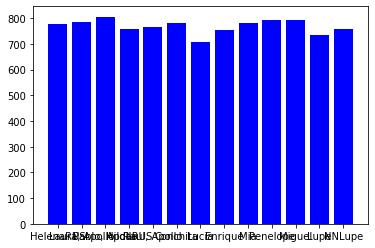

In [7]:
azure_opt=0
polly_opt=0
dic_voice={}
#Init the dict to zero values for each voice (key)
for voice in voice_list:
    dic_voice[voice]=0
#Populate the dict adding 1 whenever each voice is select, and in different groups.
for i in range(10000):
    voice=random.choice(voice_list)
    dic_voice[voice]+=1
    if voice in voice_list_Azure:
        azure_opt+=1
    else:
        polly_opt+=1

print(polly_opt, azure_opt)
print(dic_voice)
plt.bar(dic_voice.keys(), dic_voice.values(), color='b')

We add the synthethic paths to the dataframe, and check that the path is correct and we can load the file

In [8]:
df['synpath']=synthethicpaths
print(df['synpath'][90])
ipd.Audio(df['synpath'][90]) # load a local WAV file

/home/javio/Audio/Common Voice/Spanish/SYNclips/SYN_Raul, Apollo_common_voice_es_19598233.wav


To rearrange the  order of columns, we are going to move client id to the end, and put the path and synthetic path at the beginning

In [9]:
cols = df.columns.tolist();cols
new_cols= ['path',
 'synpath',
 'sentence',
 'up_votes',
 'down_votes',
 'age',
 'gender',
 'accent',
 'client_id']
df = df[new_cols]

In [16]:
df.to_csv('syndf.csv', index=False,sep='\t',columns=new_cols[:3])

# <center> How to preprocess the natural dataset

This is the file we are going to use to see everything works correctly.
We load it and play it

In [184]:
df['path'][0]

'common_voice_es_19698530.mp3'

In [4]:
natfolder = '/home/javio/Audio/Common Voice/Spanish/clips/'
file=natfolder+df.path[0]
ipd.Audio(file)

To check the framerate and dbfs we use another library

In [12]:
from pydub import AudioSegment
song = AudioSegment.from_mp3(file)
print(f"Framerate is {song.frame_rate}")
print(f"dBFS is {round(song.max_dBFS,3)}")
song

Framerate is 48000
dBFS is -1.156


In [14]:
file

'/home/javio/Audio/Common Voice/Spanish/clips/common_voice_es_19698530.mp3'

We check the same values for the file we have normalized to 0dBFS using sox. It sounds the same

In [13]:
normfile='/home/javio/Audio/Common Voice/norm.mp3'
ipd.Audio(normfile)
songnorm = AudioSegment.from_mp3(normfile)
print(f"Framerate is {songnorm.frame_rate}")
print(f"dBFS is {round(songnorm.max_dBFS,3)}")
songnorm

Framerate is 48000
dBFS is -0.699


We start loading into librosa, converting to 16kHz and trimming silences at the beginning/end of the audios

In [266]:
y, sr = librosa.load(file,sr=16000)
# Trim the beginning and ending silence
yt, index = librosa.effects.trim(y,top_db=10)
print(sr)
ipd.Audio(data=(yt), rate=sr)

16000


In [175]:
print(f"Audio was trimmed {round(librosa.get_duration(y) - librosa.get_duration(yt),3)} seconds")

Audio was trimmed 0.807 seconds


We plot the trimmed waveplot

-0.8333086


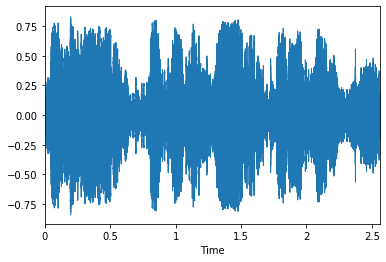

In [330]:
print(yt.min())
librosa.display.waveplot(yt, sr=sr)

We transform to dB, and display the waveplot

-1.583883 -81.583885


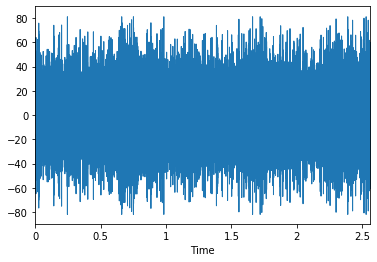

In [379]:
ydb = librosa.amplitude_to_db((yt))
print(ydb.max(),ydb.min())
librosa.display.waveplot(ydb, sr=sr)

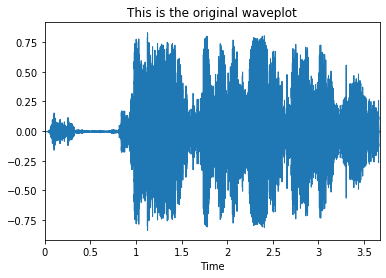

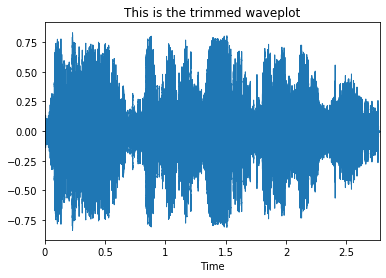

-1.583883 -81.583885


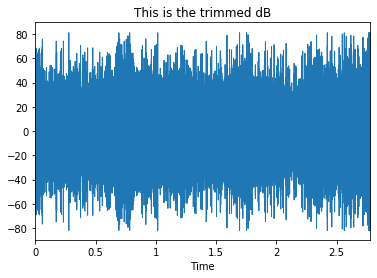

In [6]:
#Here we are going to compare using the SoX-normalized file
y, sr = librosa.load(file,sr=16000)
librosa.display.waveplot(y, sr=sr)
plt.title('This is the original waveplot')
plt.show()
# Trim the beginning and ending silence
yt, index = librosa.effects.trim(y,top_db=15)
librosa.display.waveplot(yt, sr=sr)
plt.title('This is the trimmed waveplot')
plt.show()
ydb = librosa.amplitude_to_db((yt))
print(ydb.max(),ydb.min())
librosa.display.waveplot(ydb, sr=sr)
plt.title('This is the trimmed dB')
plt.show()
ipd.Audio(data=(yt), rate=sr)

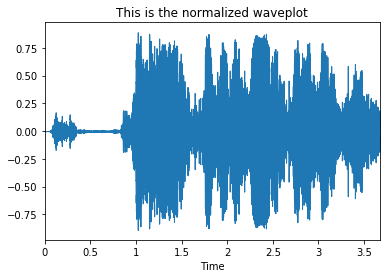

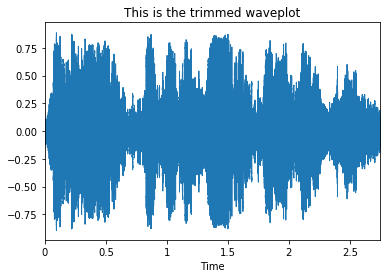

-1.583883 -81.583885


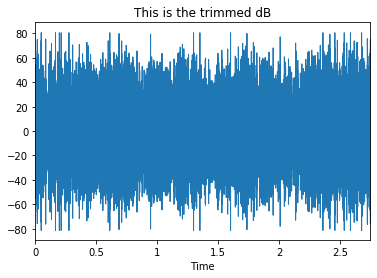

In [15]:
#Here we are going to compare using the SoX-normalized file
yn, sr = librosa.load(normfile,sr=16000)
librosa.display.waveplot(yn, sr=sr)
plt.title('This is the normalized waveplot')
plt.show()
# Trim the beginning and ending silence
ytn, index = librosa.effects.trim(yn,top_db=15)
librosa.display.waveplot(ytn, sr=sr)
plt.title('This is the trimmed waveplot')
plt.show()
yndb = librosa.amplitude_to_db((ytn))
print(ydb.max(),ydb.min())
librosa.display.waveplot(yndb, sr=sr)
plt.title('This is the trimmed dB')
plt.show()
ipd.Audio(data=(ytn), rate=sr)

In [377]:
#This normalizes the spectrogram to a max of 1 min of 0.
def normalizeWaveplot(y):
    return (y-y.min())/(y-y.min()).max()

0.0


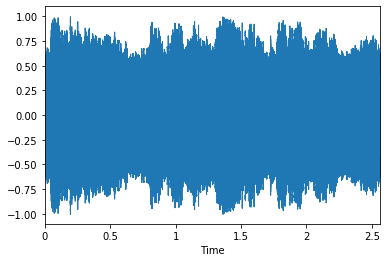

In [380]:
ytnorm=normalizeWaveplot(yt)
print(ytnorm.min())
librosa.display.waveplot(ytnorm, sr=sr)
ipd.Audio(data=ytnorm, rate=sr)

0.0 -80.0


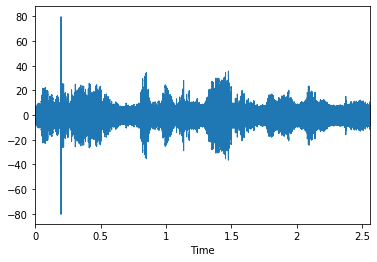

In [383]:
ytnormdb = librosa.amplitude_to_db((ytnorm))
print(ytnormdb.max(),ytnormdb.min())
librosa.display.waveplot(ytnormdb, sr=sr)


In [323]:
yn, sr = librosa.load(normfile,sr=16000)
# Trim the beginning and ending silence
ytn, index = librosa.effects.trim(yn,top_db=10)
print(sr)
ipd.Audio(data=(ytn), rate=sr)

16000


-0.8779183


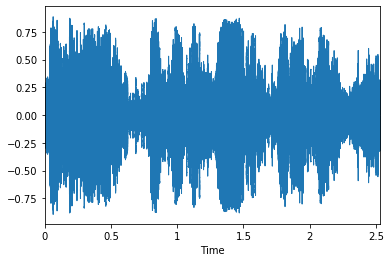

In [325]:
print(ytn.min())
librosa.display.waveplot(ytn, sr=sr)

# <center> This is minicode to plot without using provided libraries

In [361]:
def create_time_function(y,sr=16000):
    return np.linspace(0,y.shape[0]/sr,y.shape[0])
time=create_time_function(yt)
yt.shape

(40960,)

(0.15778086, 0.51092833)

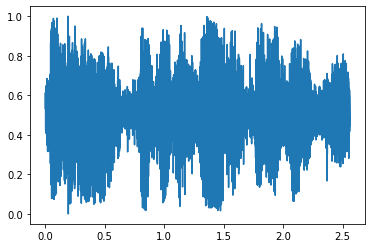

In [374]:
plt.plot(time,corr)
corr.std(),corr.mean()

(0.25712395, -0.0006859943)

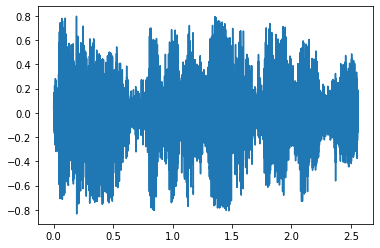

In [368]:
#Maybe its better if it is centered around 0., not 0.5
plt.plot(time,yt)
yt.std(),yt.mean()

# <center> Diff between synthetic - natural voices

In [64]:
index_path=10

First we'll load some examples to compare between the same audio file read by natural and synthetic voice

In [2]:
print(df['path'][index_path])
natfolder = '/home/javio/Audio/Common Voice/Spanish/clips/'
natfile=natfolder+df.path[index_path]

ipd.Audio(natfile)

ynat, sr = librosa.load(natfile,sr=16000)
# Trim the beginning and ending silence
ytnat, _ = librosa.effects.trim(ynat,top_db=10)

librosa.display.waveplot(ytnat, sr=sr)

#ydb = librosa.amplitude_to_db(yt)
#librosa.display.waveplot(ydb, sr=sr)
ipd.Audio(data=ytnat, rate=sr)


NameError: name 'df' is not defined

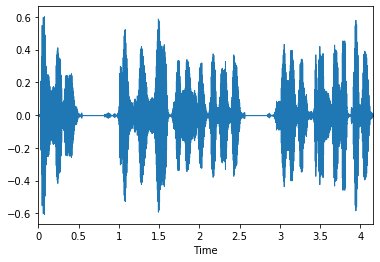

In [66]:
synfile=df.synpath[index_path]

ipd.Audio(synfile)

ysyn, sr = librosa.load(synfile,sr=16000)
# Trim the beginning and ending silence
ytsyn, index = librosa.effects.trim(ysyn,top_db=10)


librosa.display.waveplot(ytsyn, sr=sr)
ipd.Audio(data=ysyn, rate=sr)

In [53]:
df

,path,synthpaths,sentence,up_votes,down_votes,age,gender,accent,client_id
0,common_voice_es_19698530.mp3,/home/javio/Audio/Common Voice/Spanish/SYNclip...,Habita en aguas poco profundas y rocosas.,2,1,thirties,male,mexicano,0003b969350f5308dc7347c574bc291834f38fdd92a286...
1,common_voice_es_19987333.mp3,/home/javio/Audio/Common Voice/Spanish/SYNPoll...,Opera principalmente vuelos de cabotaje y regi...,2,1,NaN,NaN,NaN,009891ef9a0c11e1b21a9d8a8318c493382963c9eac3ab...
2,common_voice_es_19691402.mp3,/home/javio/Audio/Common Voice/Spanish/SYNclip...,Para visitar contactar primero con la dirección.,2,0,NaN,NaN,NaN,00b0a5cf01f152b2b6771f16e34118a1d95e29716e4c86...
3,common_voice_es_19966634.mp3,/home/javio/Audio/Common Voice/Spanish/SYNclip...,"Realizó los estudios primarios en Francia, par...",2,1,NaN,NaN,NaN,00de0234aec2cb4d2268ef5b5ba1d72d84ce36fa032096...
4,common_voice_es_19600147.mp3,/home/javio/Audio/Common Voice/Spanish/SYNclip...,"En los años que siguieron, este trabajo Espart...",2,0,NaN,NaN,NaN,00f3644640cf32c29fda40403d82ca131e97d93e92cb79...
...,...,...,...,...,...,...,...,...,...
13216,common_voice_es_19622792.mp3,/home/javio/Audio/Common Voice/Spanish/SYNPoll...,"Sus obras completas, en once volúmenes, están ...",2,0,NaN,NaN,NaN,5526c70d82347140a373592396cc54675c48406fb31fe9...
13217,common_voice_es_19622793.mp3,/home/javio/Audio/Common Voice/Spanish/SYNPoll...,Cuenta con unos bellos paisajes naturales.,2,1,NaN,NaN,NaN,5526c70d82347140a373592396cc54675c48406fb31fe9...
13218,common_voice_es_19622795.mp3,/home/javio/Audio/Common Voice/Spanish/SYNclip...,Hasta la fecha no ha sido autorizada una inves...,2,0,NaN,NaN,NaN,5526c70d82347140a373592396cc54675c48406fb31fe9...
13219,common_voice_es_18385237.mp3,/home/javio/Audio/Common Voice/Spanish/SYNPoll...,El suyo será de hilo de cobre.,2,0,NaN,NaN,NaN,c92f2469dbeed0d17c11b8262b62ef776ed1f73317b8cb...


### We are going to plot random waveplots of synthetic voices to see if they all look clean

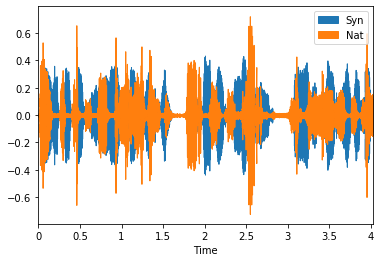

The difference in length between natural and synthetic is -0.224


In [415]:
diffs=[]
natfolder = '/home/javio/Audio/Common Voice/Spanish/clips/'

for i in range(0,1):
    index=random.choice(range(0,len(df.synpath)))
    
    ysyn, sr = librosa.load(df.synpath[index],sr=16000)
    ytsyn, _ = librosa.effects.trim(ysyn,top_db=10)
    librosa.display.waveplot(ytsyn, sr=sr,label='Syn')
    natfile=natfolder+df.path[index]

    ynat, sr = librosa.load(natfile,sr=16000)
    ytnat, _ = librosa.effects.trim(ynat,top_db=10)
    librosa.display.waveplot(ytnat, sr=sr,label='Nat')
    plt.legend()
    plt.show()
    diffs.append(round((len(ytnat)-len(ytsyn))/16000,3))
    print(f"The difference in length between natural and synthetic is {round((len(ytnat)-len(ytsyn))/16000,3)}")

In [416]:
ipd.Audio(data=ytnat, rate=sr)

In [417]:
ipd.Audio(data=ytsyn, rate=sr)

### Plot the differences in duration between nat and syn audios on a histogram

In [5]:
diffs=[]
diffs_trimmed=[]
files_missing=[]
natfolder = '/home/javio/Audio/Common Voice/Spanish/clips/'

import time
start_time = time.clock()

for i in range(0,10):
    try:
        index=random.choice(range(0,len(df.path)))
        ysyn, sr = librosa.load(df.synpath[index],sr=16000)
        ytsyn, _ = librosa.effects.trim(ysyn,top_db=10)

        natfile=natfolder+df.path[index]
        ynat, sr = librosa.load(natfile,sr=16000)
        ytnat, _ = librosa.effects.trim(ynat,top_db=10)
        
        diffs.append(round((len(ynat)-len(ysyn))/16000,3))
        diffs_trimmed.append(round((len(ytnat)-len(ytsyn))/16000,3))
    except FileNotFoundError:
        print('A file was not found')
        files_missing.append(df.synpath[i])
print(time.clock() - start_time, "seconds")

AttributeError: 'DataFrame' object has no attribute 'synpath'

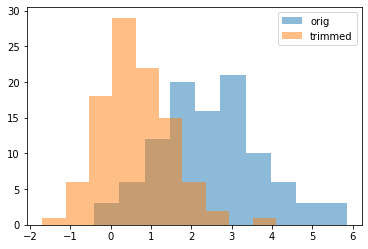

In [419]:
plt.hist(diffs,alpha=0.5,label='orig')
plt.hist(diffs_trimmed,alpha=0.5,label='trimmed')
plt.legend()

In [420]:
## To check if SoX norm is needed

In [24]:
from pydub import AudioSegment
file='/home/javio/Audio/Common Voice/Spanish/norm.mp3'
song = AudioSegment.from_mp3(file)
print(f"Framerate is {song.frame_rate}")
print(f"dBFS is {round(song.max_dBFS,3)}")
song

FileNotFoundError: [Errno 2] No such file or directory: '/home/javio/Audio/Common Voice/Spanish/norm.mp3'

In [47]:
file='/home/javio/Audio/CommonVoice/normal.wav'
song = AudioSegment.from_mp3(file)
print(f"Framerate is {song.frame_rate}")
print(f"dBFS is {round(song.max_dBFS,3)}")
song

Framerate is 48000
dBFS is -0.0


In [29]:
def waveplot(file):
    ysyn, sr = librosa.load(file,sr=16000)
    ytsyn, _ = librosa.effects.trim(ysyn,top_db=40)
    librosa.display.waveplot(ysyn, sr=sr,label='')
    return ysyn,ytsyn

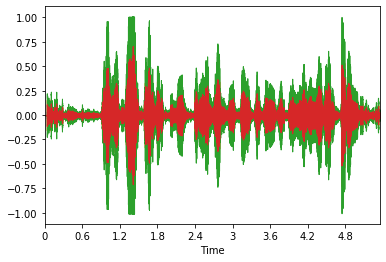

In [30]:
y,yt=waveplot(file)
file2='/home/javio/Audio/CommonVoice/normal.wav'
y2,yt2=waveplot(file2)
file3='/home/javio/Audio/CommonVoice/normal3.wav'
y3,yt3=waveplot(file3)
file33='/home/javio/Audio/CommonVoice/normal-3.wav'
y33,yt33=waveplot(file33)

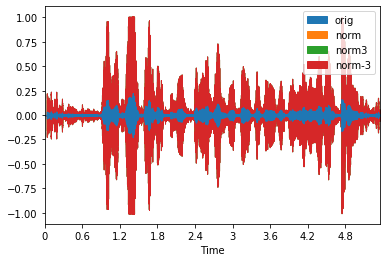

In [41]:
sr=16000
librosa.display.waveplot(y, sr=sr,label='orig',zorder=1)
librosa.display.waveplot(y2, sr=sr,label='norm',zorder=0)
librosa.display.waveplot(y3, sr=sr,label='norm3',zorder=0)
librosa.display.waveplot(y3, sr=sr,label='norm-3',zorder=0)

plt.legend()

If the original audio is very low volume, a norm is neeed to make it more similar to synth speech

# <center> Function for inference processing - get_waveplot & parallel

We want to load, preprocess and obtain waveplot

In [3]:
def get_waveplot(file,dest='/proc/',plots='/plots/'):
    try:
        #I need to convert the file to wav, norm, 
        #trim silence (anything less than 3% volume) until we encounter sound lasting more than 0.5 seconds in duration
        proc='_p'
        ext='.wav'
        #I create a new file with added _p.wav at the end
        subprocess.call(f"sox \"{str(file)}\" -r 16000 \"{str(file)[:-4]+proc+ext}\" norm silence 1 0.1 3% -1 0.1 3%", shell=True)

        #I moved said _p.wav file to the dest folder.
        path = Path(file)
        destinationpath = str(path.parent) + (dest) + str(path.stem) + ext
        if not os.path.exists(str(path.parent) + (dest)):
            os.mkdir(str(path.parent) + (dest))
        subprocess.call(f"mv \"{str(file)[:-4]+proc+ext}\" \"{destinationpath}\"", shell=True)

        #Load the audio, create waveplot and save it in the plot dir
        y, sr = librosa.load(Path(destinationpath),sr=16000)

        librosa.display.waveplot(y, sr=sr)

        plot = str(path.parent) + (plots) + str(path.name)
        if not os.path.exists(str(path.parent) + (plots)):
            os.mkdir(str(path.parent) + (plots))
        plt.savefig(Path(plot).with_suffix('.png'))
        plt.clf()
    except FileNotFoundError as not_found:
        print(not_found.filename)
    except librosa.util.exceptions.ParameterError as short_file:
        print(file)

def handle_waveplot_batches(file,**kwargs):
    #To handle file/batch of files(folder)
    path=Path(file)
    if not path.exists(): print('Path does not exist')
    else:
        if path.is_file():
            get_waveplot(file,**kwargs)        
        else:
            #If it is not a file, we assume it's a folder
            for each in path.iterdir():
                if each.is_file():
                    get_waveplot(str(each),**kwargs)        

In [28]:
file='/home/javio/Audio/CommonVoice/totrim.mp3'
folder='/home/javio/Audio/CommonVoice/Spanish/dummy/'

import time
start_time = time.clock()
#get_waveplot(file,'/proc/','/plots/')
%timeit -n 1 handle_waveplot_batches(folder)
print(f"{time.clock() - start_time}, seconds to do 4 items")

3.41 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.793469999999957, seconds to do 4 items


<Figure size 432x288 with 0 Axes>

In [27]:
file='/home/javio/Audio/CommonVoice/totrim.mp3'
folder='/home/javio/Audio/CommonVoice/Spanish/dummy/'

import time
lista=[(file) for file in Path(folder).iterdir() if file.is_file()]

start_time = time.clock()
#get_waveplot(file,'/proc/','/plots/')
%timeit -n 1 Parallel (n_jobs=num_cores) (delayed (get_waveplot) (file) for file in lista)
print(f"{time.clock() - start_time}, seconds to do 4 items")

1.5 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
0.15150500000004286, seconds to do 4 items


The time.clock trick does not work for the Parallel instruction, instead I used %timeit
We get about a 3.4/1.5 = 2.25 times faster performance

This is the code I used in parallel to obtain all the waveplots
#Didn't use trimming

# THIS IS WHAT I NEED TO EXECUTE FIRST TO CONTINUE THE LOOP

In [12]:
folder='/home/javio/Audio/CommonVoice/Spanish/SYNPollyclips/'
num_cores = multiprocessing.cpu_count()
lista=[(file) for file in Path(folder).iterdir() if file.is_file()]
#filtered=[Path(folder+file.name) for file in Path(folder+'/proc/').iterdir()]
#set_difference = set(lista) - set(filtered)
#list_difference = list(set_difference)

start_time = time.clock()
Parallel (n_jobs=num_cores) (delayed (get_waveplot) (file) for file in lista)
print(f"{time.clock() - start_time} seconds to do 13221 items")

234.135156 seconds to do 13221 items


In [11]:
folder='/home/javio/Audio/CommonVoice/Spanish/SYNPollyclips/'

lista=[(file) for file in Path(folder).iterdir() if file.is_file()]
filtered=[Path(folder+file.name) for file in Path(folder+'/proc/').iterdir()]
len(filtered)
set_difference = set(lista) - set(filtered)
list_difference = list(set_difference)
len(list_difference)

FileNotFoundError: [Errno 2] No such file or directory: '/home/javio/Audio/CommonVoice/Spanish/SYNPollyclips/proc'

Now to do the natural clips found in train.tsv

In [8]:
    
folder='/home/javio/Audio/CommonVoice/Spanish/clips/'
num_cores = multiprocessing.cpu_count()
lista=[(file) for file in df.path]
filtered=[(folder+file.name) for file in Path(folder+'/proc/').iterdir()]
set_difference = set(lista) - set(filtered)
list_difference = list(set_difference)
print(list_difference)
#Parallel (n_jobs=num_cores) (delayed (get_waveplot) (file) for file in list_difference)

[]


In [11]:
lista[0], filtered[0]

('/home/javio/Audio/CommonVoice/Spanish/SYNPollyclips/SYNP_Conchita_common_voice_es_19698530.wav',
 '/home/javio/Audio/CommonVoice/Spanish/SYNclips/SYN_HildaRUS_common_voice_es_18921150.wav')

First cell looks for corrupted images, second cell looks for empty (0 bytes) files

In [69]:
from PIL import Image
errors=[]
for image in Path(folder+'plots/').iterdir():
    try:
        im = Image.open(image)  
    except OSError:
        errors.append(image)

In [72]:
empty=[]
for image in Path(folder+'proc/').iterdir():
    if not (os.path.getsize(image) > 0):empty.append(image)

In [60]:
#For the dummy example
from joblib import Parallel, delayed
import multiprocessing
folder='/home/javio/Audio/CommonVoice/Spanish/dummy/'
num_cores = multiprocessing.cpu_count()
lista=[(file) for file in Path(folder).iterdir() if file.is_file()]
filtered=[(file) for file in Path(folder+'/proc/').iterdir() if file.is_file()]
start_time = time.clock()
Parallel (n_jobs=num_cores) (delayed (get_waveplot) (file) for file in lista)
print(f"{time.clock() - start_time}, seconds to do 13221 items")

0.0672440000000023, seconds to do 13221 items


In [10]:
#This idea should be used to create parallel processing codes to create waveplots on large sets.
rango=[0,1,2,3,4,5,6,7,8,9]
for i in range(0,int(np.ceil(len(rango)/2))):
    print(i)
for j in range(int(np.ceil(len(rango)/2)),len(rango)):
    print(j)

0
1
2
3
4
5
6
7
8
9


## <center> I need to move the plots of the files in synpath

In [67]:
# df.synpath[0],df.synpath[1]
#I need to add /plots/ after the name, and the extension for .png
dest=Path('/home/javio/Audio/CommonVoice/Spanish/waveplots/synthetic/')
for file in df.synpath:
    path=Path(file)
    route=path.parent / 'plots' / (path.stem+('.png'))
    subprocess.call(f"cp \"{str(route)}\" \"{str(dest)}\"", shell=True)

In [66]:
#To copy all the natural audio files from the clips/plots to the waveplots folder
dest=('/home/javio/Audio/CommonVoice/Spanish/waveplots/natural')
orig=('/home/javio/Audio/CommonVoice/Spanish/clips/plots/*')
subprocess.call(f"cp {str(orig)} {str(dest)}", shell=True)

0

# <center> Some ideas not used

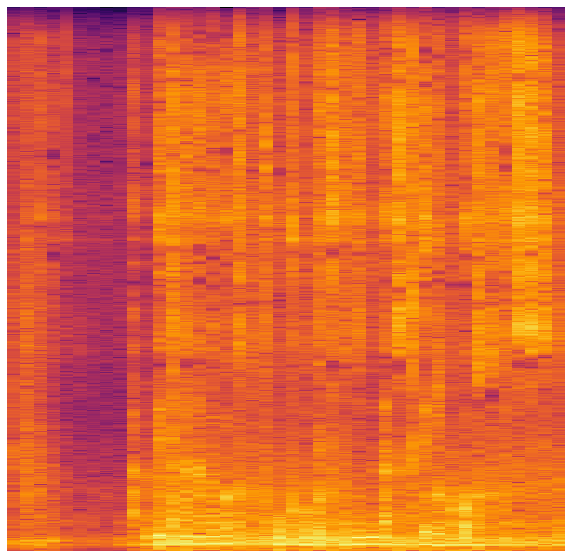

In [8]:
natfolder = '/home/javio/Audio/Common Voice/Spanish/clips/'
natfile=natfolder+df.path[0]
y, sr = librosa.load(natfile, mono=True, duration=5)
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(10,10))
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
plt.axis('off');
plt.show()

In [16]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [17]:
header

['filename',
 'chroma_stft',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [18]:
casa='estacasa';amigo='invisible'
f'{casa} {amigo}'

'estacasa invisible'

In [ ]:
#Encoding the Labels

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

#Scaling the Feature columns

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))


#Dividing data into training and Testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)